In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import plotly.graph_objs as go
from pandas.tseries.offsets import BDay

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from util.functions import get_data_ticker, gerar_dias_uteis, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import keras
from keras.layers import Input, LSTM, Dense, Dropout
from keras import Sequential


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parâmetros

In [2]:
EMPRESA = 'VALE3.SA'
SEED = 42
qtdTreino = .9

# features = ['Close', 'prev-day-1', 'prev-day-2', 'prev-day-3', 'mm_5', 'mm_21', 'Close_diff']
features = ['Close','Close_diff', 'mm_5', 'mm_21']
features_trend = ['Close','tomorrow']
target = 'tomorrow'

n_past = 15
days_to_predict = 14
# n_features = len(features)

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Funções

In [3]:
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

In [4]:
def prepare_new_record(df, new_record, date_index, rolling=1):
    data_orig = pd.DataFrame({'Close': new_record}, index=[date_index])
    data_orig = data_orig.rename_axis('Date')
    data_orig = pd.concat([df,data_orig])
    data_hist = pd.DataFrame(data_orig['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(rolling).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(rolling).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(rolling).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist['tomorrow'] = data_hist['Close'].rolling(rolling).mean().shift(-1)
    data_hist['Close_diff'] = data_hist['Close'].diff().dropna()
    data_hist['tomorrow'].fillna(0, inplace = True)
    return data_hist.tail(1)

In [5]:
def increment_data_df(df, last_predict, offset=0):
   if df.tail(1)['tomorrow'].values[0] == 0:
      return df
   # dia_util = gerar_dias_uteis(1, offset)[0]
   last_date = df.index[-1]
   dia_util = pd.date_range(start=last_date + BDay(1), periods=1, freq=BDay())

   return pd.concat([df, prepare_new_record(df, last_predict, dia_util[0])])

In [6]:
def evaluate_model(y_true, y_pred):
    # Calcular as métricas de desempenho
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # Criar um dicionário com as métricas
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    
    return metrics

In [7]:
def aplicar_tendencia_coluna(df, coluna, period = 20):
    season = decompor_sinal(df[coluna], period=period, two_sided=False )
    tendencia = season.trend
    tendencia.dropna()
    df.loc[tendencia.dropna().index].copy()
    df[coluna] = tendencia

## Obter dados

In [8]:
dados = get_data_ticker(EMPRESA, period='5y', dropna=False)
dados['Close_diff'] = dados['Close'].diff().dropna()

dados.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


## Decomposição

### Análises para descobrir o melhor "period"

#### ACF

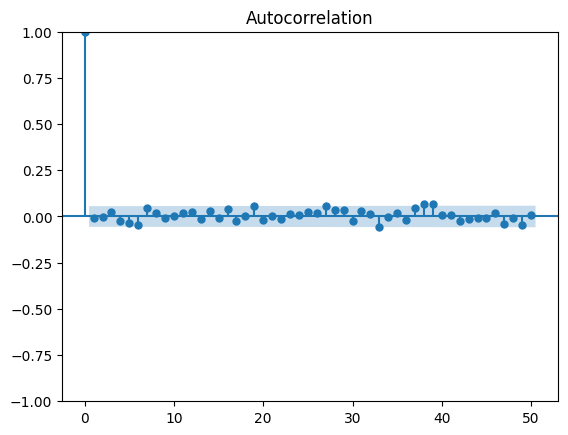

In [9]:
plot_acf(dados['Close_diff'], lags=50) 
plt.show()

### Seasonal decompose

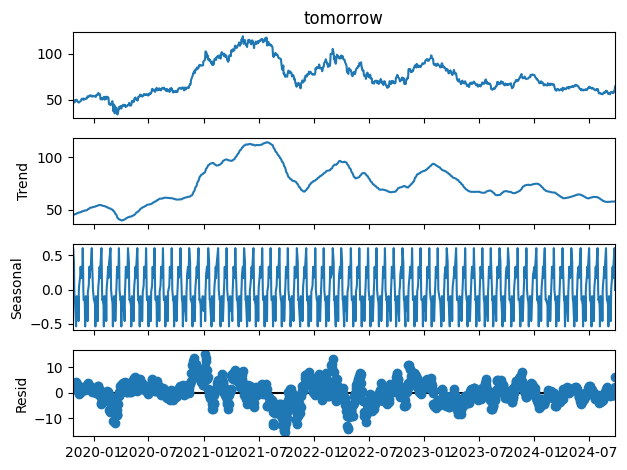

In [10]:
if 'tomorrow' in features_trend:
    season = decompor_sinal(dados['tomorrow'], period=20 )
    tendencia = season.trend

    season.plot()
    plt.show()

## Pré processamento

In [11]:
for f in features_trend:
    aplicar_tendencia_coluna(dados, f)

In [12]:
fig = px.line(dados, y=['mm_5', 'mm_21', 'Close', 'tomorrow'])
fig.update_layout(
    title=dict(text="médias móveis X tendencia", font=dict(size=50), automargin=True, yref='paper')
)
fig.show()

Separando dados de treino e teste

In [13]:
def split_X_y(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)
    X, y = create_sequences(df_scaled[features].values, df[target].values, n_past)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=qtdTreino, shuffle=False)
    return (X, y, X_train, X_test, y_train, y_test)

In [14]:
X, y, X_train, X_test, y_train, y_test = split_X_y(dados)

In [15]:
if 'Close' in features:
    close_index = features.index('Close')

    close_values= [X_train[i, :, close_index] for i in range(X_train.shape[0])]
    X_train_plot = [arr[0] for arr in close_values]

    close_values= [X_test[i, :, close_index] for i in range(X_test.shape[0])]
    X_test_plot = [arr[0] for arr in close_values]


In [16]:

dtr_plot = pd.DataFrame({'tomorrow':y_train})
dte_plot = pd.DataFrame({'tomorrow':y_test})
dtr_plot['tipo'] = 'treino'
dte_plot['tipo'] = 'teste'

# Adicionar índices sequenciais
dtr_plot['index'] = range(len(dtr_plot))
dte_plot['index'] = range(len(dtr_plot), len(dtr_plot) + len(dte_plot))

# Concatenar os DataFrames
dados_concat = pd.concat([dtr_plot, dte_plot])

# Criar o gráfico
fig = px.line(dados_concat, x='index', y='tomorrow', color='tipo')

# Atualizar o layout do gráfico
fig.update_layout(
    title=dict(text="Split treino X teste", font=dict(size=50), automargin=True, yref='paper'),
    xaxis_title='Índice',
    yaxis_title='Valor de Fechamento'
)

# Exibir o gráfico
fig.show()

## Modelos

### Prophet

In [17]:
np.random.seed(42)

df_prophet = pd.DataFrame()
df_prophet['ds'] = dados.index
df_prophet['y'] = dados['Close'].reset_index(drop=True)

tamanho_treino = int(len(df_prophet)*.8)
tamanho_teste = int(len(df_prophet)*.2)

df_treino = df_prophet[:tamanho_treino]
df_teste = df_prophet[tamanho_treino:]

modelo_prophet = Prophet()
modelo_prophet.fit(df_treino)

futuro = modelo_prophet.make_future_dataframe(periods=len(df_teste), freq='D')
previsao = modelo_prophet.predict(futuro)

23:31:29 - cmdstanpy - INFO - Chain [1] start processing
23:31:29 - cmdstanpy - INFO - Chain [1] done processing


MSE: 41.95; RMSE: 6.48


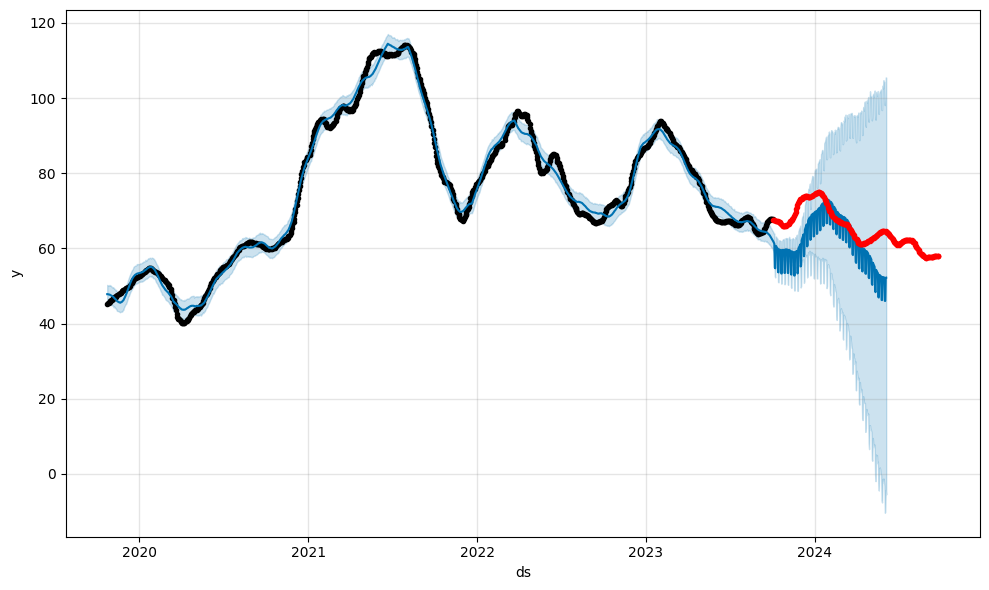

In [18]:
modelo_prophet.plot(previsao)

plt.plot(df_teste['ds'],df_teste['y'],'.r')

from sklearn.metrics import mean_squared_error

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds', how='inner')

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat']).round(2)
rmse = np.sqrt(mse).round(2)
print(f'MSE: {mse}; RMSE: {rmse}')

In [19]:
# modelo_prophet = Prophet()
# modelo_prophet.fit(df_prophet)

# futuro = modelo_prophet.make_future_dataframe(periods=0, freq='D')
# previsao = modelo_prophet.predict(futuro)

# df_prophet_sem_outliers = df_prophet[(df_prophet['y'] > previsao['yhat_lower']) & (df_prophet['y'] < previsao['yhat_upper'])]

# modelo_prophet.plot()

### LSTM

#### Criação do modelo

In [20]:
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name='Input'))
modelo_lstm.add(LSTM(500, name='LSTM'))
# modelo_lstm.add(Dense(50, activation='relu', name='Dense_50_1'))
# modelo_lstm.add(Dense(100, activation='relu',name='Dense_50_2'))
# modelo_lstm.add(Dense(20, activation='relu',name='Dense_50_3'))
modelo_lstm.add(Dense(units=1, name='Output'))

# utilizar optimizer adam ou RMSProp
modelo_lstm.compile(optimizer='RMSProp', loss='mean_squared_error')

In [21]:
modelo_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 500)            │     1,010,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,501 (3.85 MB)

 Trainable params: 1,010,501 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

#### Treinamento do modelo

In [22]:
modelo_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, verbose=True)

Epoch 1/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 3165.8032 - val_loss: 245.6294
Epoch 2/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 1007.7009 - val_loss: 6.5844
Epoch 3/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 480.4545 - val_loss: 90.3914
Epoch 4/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 411.7514 - val_loss: 25.6717
Epoch 5/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 268.9735 - val_loss: 11.5030
Epoch 6/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 121.9925 - val_loss: 26.8513
Epoch 7/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 73.8903 - val_loss: 7.2166
Epoch 8/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 54.2968 - val_loss: 6.9791


#### Predição do modelo

In [23]:
y_pred = modelo_lstm.predict(X_test)
evaluate_model(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


{'MSE': 6.979055649335388,
 'MAE': 2.2140838741270934,
 'RMSE': 2.6417902356802268}

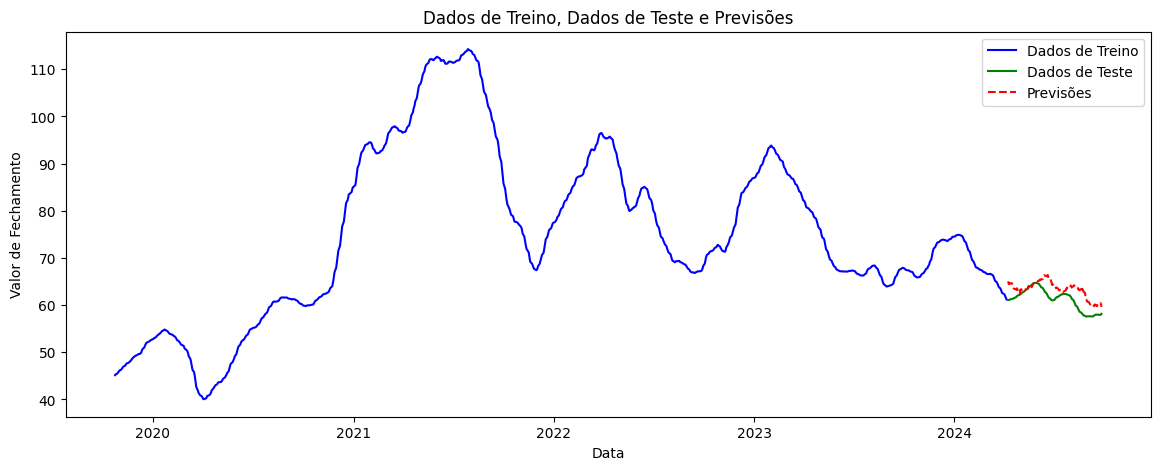

In [24]:
index_train = dados.index[:len(dados) - len(y_test)]
index_test = dados.index[len(dados) - len(y_test):]

# Valores reais de treino e teste
train_values = dados['tomorrow'][:len(dados) - len(y_test)]
test_values = dados['tomorrow'][len(dados) - len(y_test):]

# Plotando o gráfico
plt.figure(figsize=(14, 5))

# Plotando os valores reais de treino
plt.plot(index_train, train_values, color='blue', label='Dados de Treino')

# Plotando os valores reais de teste
plt.plot(index_test, test_values, color='green', label='Dados de Teste')

# Plotando as previsões
plt.plot(index_test, y_pred, color='red', linestyle='--', label='Previsões')

plt.title('Dados de Treino, Dados de Teste e Previsões')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [25]:
dados_forward = dados.copy()
last_pred = y_pred[-1]
feed_preds = []

for d in range(days_to_predict):
    dados_forward = increment_data_df(dados_forward, y_pred[-1], d)
    X_fwd, y_fwd, X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = split_X_y(dados_forward)
    last_pred = modelo_lstm.predict(X_fwd[-n_past:-1])[-1]

    dados_forward.loc[dados_forward.index[-1], 'tomorrow'] = last_pred
    feed_preds.append(last_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [26]:
fig = go.Figure()

# Linha do dataset original 'dados'
fig.add_trace(go.Scatter(x=dados.index[-(days_to_predict*5):], 
                         y=dados['tomorrow'][-(days_to_predict*5):], 
                         mode='lines', 
                         name='Dados Anteriores'))

# Linha dos dados previstos 'dados_forward'
fig.add_trace(go.Scatter(x=dados_forward.index[-(days_to_predict+1):], 
                         y=dados_forward['tomorrow'][-(days_to_predict+1):], 
                         mode='lines', 
                         name='Previsões'))

# Ajuste dos rótulos do eixo x e rotação
fig.update_layout(
    xaxis=dict(tickangle=-90),  # Rotação vertical dos rótulos
    title="Previsão de Fechamento",
    xaxis_title="Data",
    yaxis_title="Valor Fechamento",
    legend_title="Legenda",
    height=600,
    width=900
)

# Exibindo o gráfico
fig.show()